In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import platform
platform.system()

if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import random
import time

from itertools import combinations

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa

import seaborn as sns

In [3]:
dataframe = pd.read_csv("C:/Users/wjddu/git/Domestic-Solar-Power-Output-Prediction/최종 data.csv")

In [4]:
dataframe

,date,year,month,day,hour,발전량,기온,습도,이슬점 온도,일사량,구름양
0,2016-12-13 14:00,2016,12,13,14,0.136635,0.266807,0.77,0.395683,0.104651,0.0
1,2016-12-13 15:00,2016,12,13,15,0.083355,0.266807,0.80,0.413669,0.075581,0.0
2,2016-12-13 16:00,2016,12,13,16,0.031664,0.256303,0.80,0.395683,0.058140,0.0
3,2016-12-13 17:00,2016,12,13,17,0.000150,0.247899,0.80,0.381295,0.014535,0.0
4,2016-12-13 18:00,2016,12,13,18,0.000000,0.231092,0.86,0.388489,0.002907,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22487,2020-12-31 19:00,2020,12,31,19,0.000000,0.157563,0.65,0.136691,0.000000,0.8
22488,2020-12-31 20:00,2020,12,31,20,0.000000,0.144958,0.66,0.122302,0.000000,0.8
22489,2020-12-31 21:00,2020,12,31,21,0.000000,0.136555,0.75,0.169065,0.000000,0.8
22490,2020-12-31 22:00,2020,12,31,22,0.000000,0.119748,0.73,0.129496,0.000000,0.8


In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

def set_random_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


set_random_seed(seed=0)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')), tf.test.is_built_with_cuda())

Num GPUs Available: 0 True


In [6]:
X_features = ['month', 'hour', '기온', '습도', '이슬점 온도', '일사량', '구름양']
y_feature = ['발전량']

X = dataframe[X_features]
y = dataframe[y_feature]

X.shape, y.shape

((22492, 7), (22492, 1))

In [7]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_norm, y_norm = X.copy(), y.copy()
X_norm.iloc[:, 2:] = x_scaler.fit_transform(X_norm.iloc[:, 2:])
y_norm.iloc[:, :] = y_scaler.fit_transform(y_norm.iloc[:, :])

X_norm.shape, y_norm.shape

((22492, 7), (22492, 1))

In [8]:
dataframe.describe()

,year,month,day,hour,발전량,기온,습도,이슬점 온도,일사량,구름양
count,22492.000000,22492.000000,22492.000000,22492.000000,22492.000000,22492.000000,22492.000000,22492.000000,22492.000000,22492.000000
mean,2018.496043,6.488129,15.872088,11.310421,0.179410,0.406730,0.684760,0.536310,0.119420,0.287347
std,1.164338,3.750345,8.651306,7.159485,0.291302,0.165132,0.215186,0.282271,0.204601,0.388011
min,2016.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,3.000000,8.000000,5.000000,0.000000,0.275210,0.520000,0.309353,0.000000,0.000000
50%,2019.000000,5.000000,16.000000,11.000000,0.000000,0.403361,0.700000,0.539568,0.000000,0.000000
75%,2020.000000,10.000000,23.000000,18.000000,0.268931,0.531513,0.880000,0.784173,0.163518,0.700000
max,2020.000000,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
def split_sequences(feature, label, timestep=22):
    X, y = [], []
    
    for i in range(timestep, len(feature)):
        
        _X = feature[(i-timestep):i]
        _y = label[i:i+1]

        X.append(_X)
        y.append(_y)
    return np.array(X), np.array(y)

X_total, y_total = split_sequences(X_norm.values, y_norm.values.flatten())

In [10]:
X_norm

,month,hour,기온,습도,이슬점 온도,일사량,구름양
0,12,14,0.266807,0.77,0.395683,0.104651,0.0
1,12,15,0.266807,0.80,0.413669,0.075581,0.0
2,12,16,0.256303,0.80,0.395683,0.058140,0.0
3,12,17,0.247899,0.80,0.381295,0.014535,0.0
4,12,18,0.231092,0.86,0.388489,0.002907,0.0
...,...,...,...,...,...,...,...
22487,12,19,0.157563,0.65,0.136691,0.000000,0.8
22488,12,20,0.144958,0.66,0.122302,0.000000,0.8
22489,12,21,0.136555,0.75,0.169065,0.000000,0.8
22490,12,22,0.119748,0.73,0.129496,0.000000,0.8


In [11]:
y_norm

,발전량
0,0.136635
1,0.083355
2,0.031664
3,0.000150
4,0.000000
...,...
22487,0.000000
22488,0.000000
22489,0.000000
22490,0.000000


In [12]:
X_total

array([[[1.20000000e+01, 1.40000000e+01, 2.66806723e-01, ...,
         3.95683453e-01, 1.04651114e-01, 0.00000000e+00],
        [1.20000000e+01, 1.50000000e+01, 2.66806723e-01, ...,
         4.13669065e-01, 7.55811280e-02, 0.00000000e+00],
        [1.20000000e+01, 1.60000000e+01, 2.56302521e-01, ...,
         3.95683453e-01, 5.81399730e-02, 0.00000000e+00],
        ...,
        [1.20000000e+01, 9.00000000e+00, 1.91176471e-01, ...,
         1.43884892e-01, 1.16278899e-01, 0.00000000e+00],
        [1.20000000e+01, 1.00000000e+01, 2.05882353e-01, ...,
         1.69064748e-01, 2.61627785e-01, 0.00000000e+00],
        [1.20000000e+01, 1.10000000e+01, 2.22689076e-01, ...,
         1.25899281e-01, 4.12790041e-01, 0.00000000e+00]],

       [[1.20000000e+01, 1.50000000e+01, 2.66806723e-01, ...,
         4.13669065e-01, 7.55811280e-02, 0.00000000e+00],
        [1.20000000e+01, 1.60000000e+01, 2.56302521e-01, ...,
         3.95683453e-01, 5.81399730e-02, 0.00000000e+00],
        [1.20000000e+01, 

In [13]:
y_total

array([[0.12844038],
       [0.1514669 ],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [14]:
X_learn, X_test, y_learn, y_test = train_test_split(X_total, y_total, test_size=0.2, shuffle=False, random_state=0)
y_test_inv = y_scaler.inverse_transform(y_test)

# y_true_df = pd.DataFrame({'y_true': y_test_inv.ravel()})
# y_true_df.to_csv('./data_0310/total_result.csv', index=False)

X_learn.shape, X_test.shape, y_learn.shape, y_test.shape

((17976, 22, 7), (4494, 22, 7), (17976, 1), (4494, 1))

In [15]:
def create_train_valid_test(X, y, shuffle=True):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=X_test.shape[0], random_state=0, shuffle=shuffle)
    return X_train, X_val, y_train, y_val

In [16]:
def generate_model_lstm(trainX, trainy, valX, valy, units=60, name='lstm', ndx=0):
    
    start_time = time.time()
    tf.keras.backend.clear_session()
    set_random_seed(seed=0)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units))
    model.add(tf.keras.layers.Dense(1))
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto', restore_best_weights=True)
    
    filepath = './data/0222/%s_%d_best.hdf5' % (name, ndx)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    
    model.fit(trainX, trainy, epochs=100, validation_data = (valX, valy), verbose=0, shuffle=False, callbacks=[early_stop, tqdm_callback])
    print("--- %s seconds ---" % (time.time() - start_time))
    return model

def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return np.round(r2*100, 1), np.round(mae, 1), np.round(rmse, 1)

def save_result(colname, data):
    path = './data_0310/total_result.csv'
    result_df = pd.read_csv(path)
    result_df[colname] = data.ravel()
    result_df.to_csv(path, index=False)

In [17]:
X_train, X_val, y_train, y_val = create_train_valid_test(X_learn, y_learn, shuffle=False)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((13482, 22, 7), (4494, 22, 7), (13482, 1), (4494, 1))

In [18]:
model = generate_model_lstm(X_train, y_train, X_val, y_val, units=100)

y_forecast = model.predict(X_test)
y_forecast_inv = y_scaler.inverse_transform(y_forecast)
r2, mae, rmse = evaluate(y_test_inv, y_forecast_inv)


r2, rmse

Training:   0%|                                                                               0/100 ETA: ?s,  …

--- 1334.3423297405243 seconds ---


(74.2, 0.2)

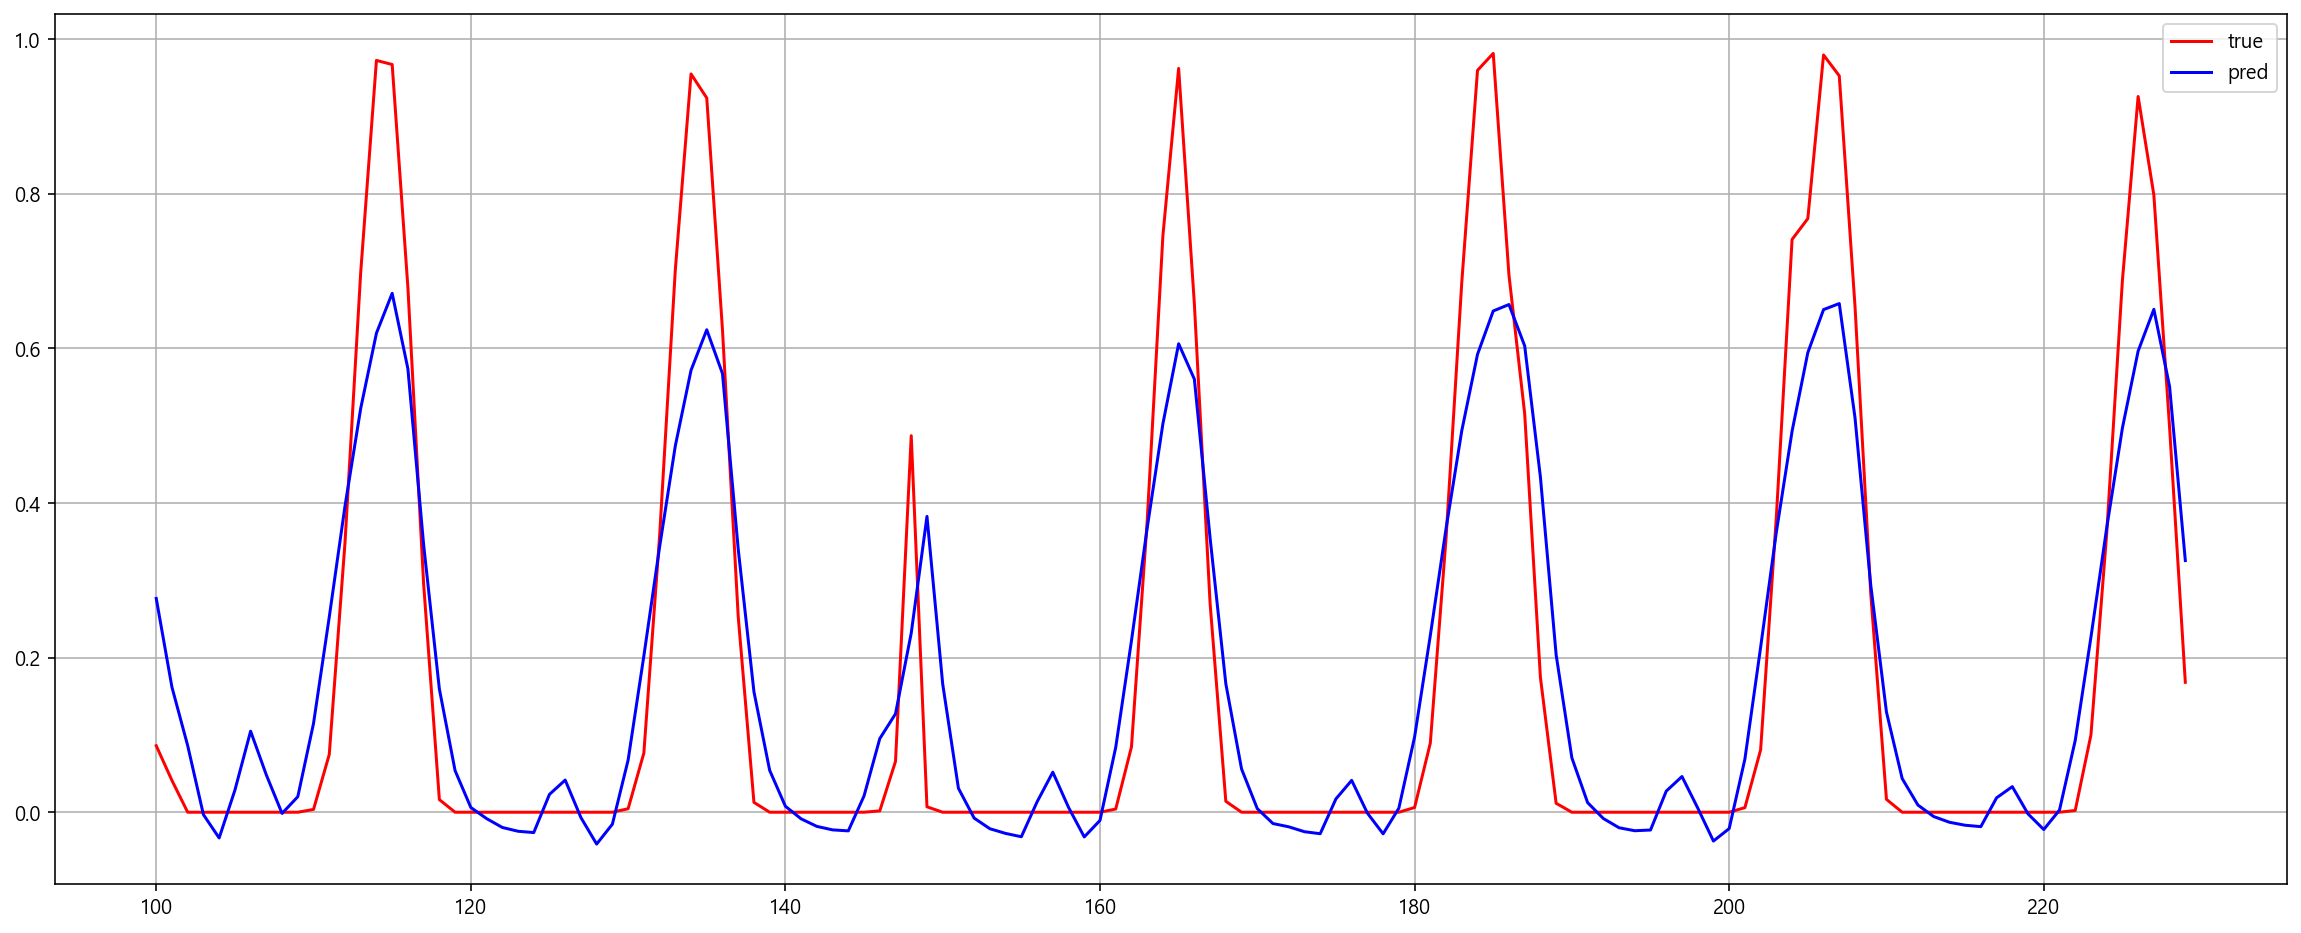

In [19]:
x_range = range(100,230)
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(x_range, y_test[x_range], color='red', label="true")
plt.plot(x_range, y_forecast[x_range], color='blue', label="pred")
plt.legend()
plt.grid()
plt.show()